# Neural Style Transfer

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import random
import cv2
import matplotlib.pyplot as plt

import copy
from scipy import ndimage

## Style transfer

The Neural Style Transfer is an algorithm that takes as input a content-image and a style-image and returns the content of the content-image as if it was ‘painted’ using the artistic style of the style-image.

For a style image I will use "The Jungle", 1942-43. <it>The Jungle</it> is a painting from the Cuban artist Wifredo Lam.

In [2]:
PATH = Path("/data2/yinterian/style-transfer/")

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(400, 383, 3)

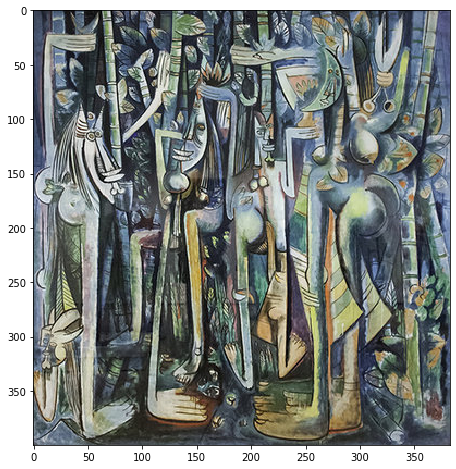

In [4]:
path = PATH/"lam.jpg"
im1 = read_image(path)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im1)
im1.shape

To get this image: <br>
`wget https://ka-perseus-images.s3.amazonaws.com/13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg
--2018-06-14 09:46:15--  https://ka-perseus-images.s3.amazonaws.com/13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg` <br>
`mv 13622ed51ffa88abd6604277fb0d8ab610fbe8e7.jpg lam.jpg`

Here is my content image. This a picture of my son. You can use your favorite content image.

(4032, 3024, 3)

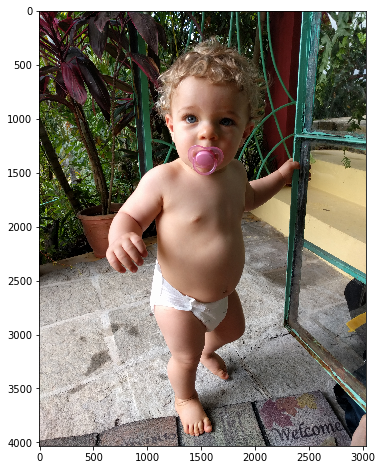

In [6]:
path2=PATH/"ari.jpg"
im2 = read_image(path2)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im2)
im2.shape

## Preprocessing
We need style and content images of the same size.

In [7]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

(300, 300, 3)

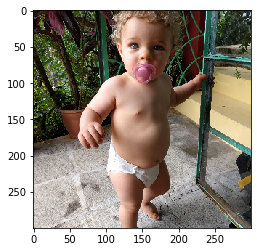

In [8]:
im2 = center_crop(im2)
im2 = cv2.resize(im2, (300, 300))
plt.imshow(im2)
im2.shape

In [9]:
im1 = center_crop(im1)
im1 = cv2.resize(im1, (300, 300))
im1.shape

(300, 300, 3)

In [10]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [11]:
im_style = transform_images(im1/255)
im_content = transform_images(im2/255)

In [12]:
im_style.shape

torch.Size([1, 3, 300, 300])

## Prepare vgg16

In [13]:
# get vgg16 model
vgg = models.vgg19(True).cuda().eval()

In [14]:
list(vgg.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace)
   (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (17): ReLU(inplace)
   (18): MaxPool2d(kernel_size=2, s

In [15]:
layers = list(vgg.children())[0]
m_vgg = nn.Sequential(*layers[:20]) # after conv4_1
# freezing parameters
for param in m_vgg.parameters():
    param.requires_grad = False

In [16]:
# indices for all Relus
block_relu = [i for i,o in enumerate(layers)
              if isinstance(o, nn.ReLU)]
block_relu

[1, 3, 6, 8, 11, 13, 15, 17, 20, 22, 24, 26, 29, 31, 33, 35]

In [17]:
# indices for all MaxPool2d
[i for i,o in enumerate(layers) if isinstance(o, nn.MaxPool2d)]

[4, 9, 18, 27, 36]

## Content optimization

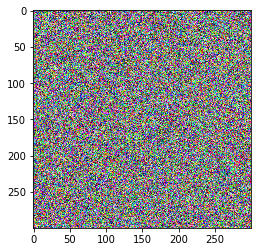

In [18]:
# start with a random image
opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
plt.imshow(opt_img)

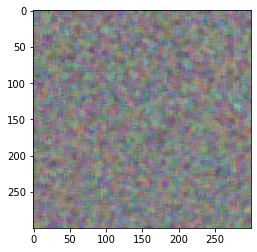

In [19]:
opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
plt.imshow(opt_img)

In [20]:
im_opt = transform_images(opt_img)
im_opt.shape

torch.Size([1, 3, 300, 300])

In [21]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
im_opt.requires_grad=True

In [22]:
optimizer = optim.Adam([im_opt], lr=0.01)

In [23]:
# the target here is the output of the content image
# after vgg16
targ_v = m_vgg(im_content)
targ_v.shape

torch.Size([1, 512, 37, 37])

In [24]:
F.mse_loss(m_vgg(im_opt), targ_v).item()

65.43504333496094

In [42]:
def get_input(lr=0.01):
    opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.Adam([im_opt], lr=0.01)
    return im_opt, optimizer

In [25]:
def train_image(optimizer, targ_v, im_opt, iters):
    for i in range(iters):
        optimizer.zero_grad()
        loss = F.mse_loss(m_vgg(im_opt), targ_v.detach())
        loss.backward()
        optimizer.step()
        im_opt.data.clamp_(0, 1)
        if i%200 == 1:
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [43]:
im_opt, optimizer = get_input(lr=0.01)

In [26]:
im_opt = train_image(optimizer, targ_v, im_opt, 2000)

41.8634147644043
1.0654025077819824
0.5471314787864685
0.36457183957099915
0.2740101218223572
0.21720410883426666
0.17971356213092804
0.15425415337085724
0.13424213230609894
0.11937633156776428


In [27]:
x = im_opt.cpu().detach().numpy()

In [28]:
x = x[0]
x.shape

(3, 300, 300)

In [29]:
x = np.rollaxis(x,0,3)

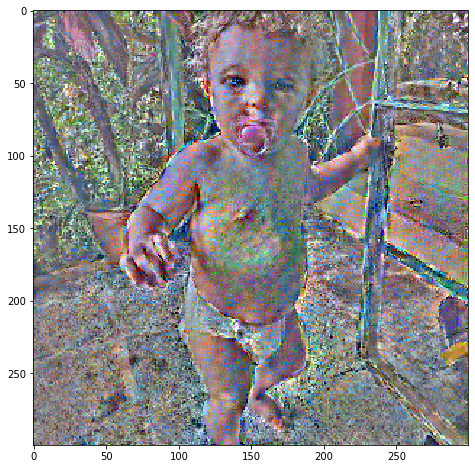

In [30]:
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(x)

## Style Optimization

For style optimization we will be using conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1. These correspond to indices: `[1, 6, 11, 20, 29]`.

In [31]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['1', '6', '11', '20', '29'] 
        self.vgg = models.vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [32]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [33]:
def get_input(lr=0.01):
    opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.Adam([im_opt], lr=0.01)
    return im_opt, optimizer

In [34]:
opt_img, optimizer = get_input(lr=0.01)
#m_vgg = get_vvg()
vgg = VGGNet().cuda().eval()

In [35]:
im_style_f = vgg(im_style)

In [36]:
[o.shape for o in im_style_f]

[torch.Size([1, 64, 300, 300]),
 torch.Size([1, 128, 150, 150]),
 torch.Size([1, 256, 75, 75]),
 torch.Size([1, 512, 37, 37]),
 torch.Size([1, 512, 18, 18])]

In [37]:
targ_g = [gram_matrix(f).detach() for f in im_style_f]

In [38]:
def train_style(optimizer, targ_g, im_opt, iters):
    for i in range(iters):
        optimizer.zero_grad()
            # run the model
        out = vgg(im_opt)
        input_g = [gram_matrix(f) for f in out]
        losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
        loss = sum(losses)
        loss.backward()     
        optimizer.step()
        im_opt.data.clamp_(0, 1)
        if i%200 == 1:
            print(loss.item())
    return im_opt

In [39]:
im_opt, optimizer = get_input(lr=0.1)

In [40]:
im_opt = train_style(optimizer, targ_g, im_opt, 2000)

6.26702094450593e-05
7.08866718923673e-06
2.692489260880393e-06
1.6181826367756003e-06
1.1615826451816247e-06
9.242028795597435e-07
7.80754589868593e-07
6.830994152551284e-07
6.114461825745821e-07
5.566170671045256e-07
5.130629574523482e-07
4.776410946760734e-07
4.481095174924121e-07
4.2313820358685916e-07
4.01821978357475e-07
3.8334675878104463e-07
3.670104149477993e-07
3.525881311361445e-07
3.3971465995819017e-07
3.281696194790129e-07


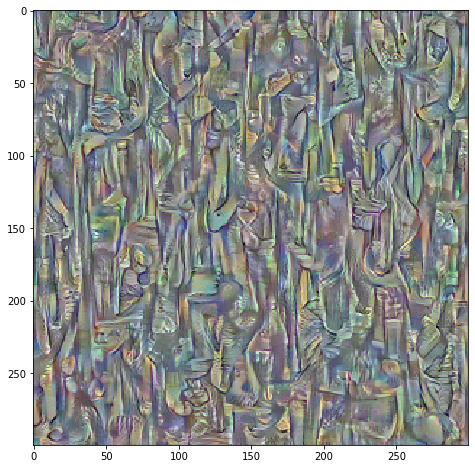

In [41]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(x)

## Style transfer
Putting everything together

In [84]:
# random image and optimizer
im_opt, optimizer = get_input(lr=0.1)

In [73]:
# here are the style and image contents
im_style = transform_images(im1/255)
im_content = transform_images(im2/255)

In [74]:
# content target
content_target = m_vgg(im_content).detach()

In [75]:
# style target
im_style_f = vgg(im_style)
style_target = [gram_matrix(f).detach() for f in im_style_f]

In [76]:
# content loss
F.mse_loss(m_vgg(im_opt), content_target)

tensor(65.1521, device='cuda:0', grad_fn=<MseLossBackward>)

In [77]:
# style loss
out = vgg(im_opt)
input_g = [gram_matrix(f) for f in out]
losses = [F.mse_loss(o, t) for o,t in zip(input_g, style_target)]
sum(losses)

tensor(6.3173e-05, device='cuda:0', grad_fn=<AddBackward0>)

In [85]:
def train_all(optimizer, im_opt, content_target, style_target, iters):
    for i in range(iters):
        optimizer.zero_grad()
        out = vgg(im_opt)
        input_g = [gram_matrix(f) for f in out]
        losses = [F.mse_loss(o, t) for o,t in zip(input_g, style_target)]
        loss = 100000*sum(losses)
        loss += F.mse_loss(m_vgg(im_opt), content_target)/10
        loss.backward()     
        optimizer.step()
        im_opt.data.clamp_(0, 1)
        if i%200 == 1:
            print(loss.item())
    return im_opt

In [86]:
im_opt = train_all(optimizer, im_opt, content_target, style_target, 3000)

10.88637638092041
1.0967388153076172
0.9676558375358582
0.9178372025489807
0.8912478685379028
0.8730282783508301
0.8593068718910217
0.8488835096359253
0.8419777154922485
0.8350597620010376
0.8307802677154541
0.8281046152114868
0.823276162147522
0.8190379738807678
0.8170983791351318


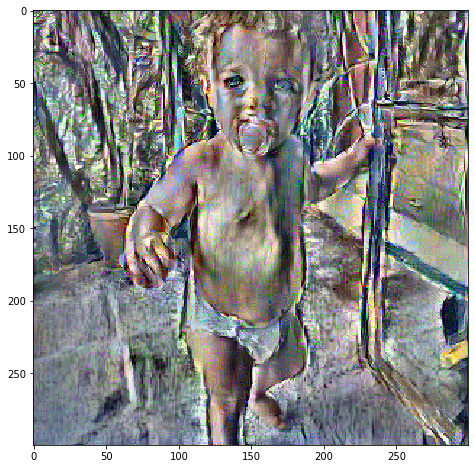

In [87]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(x)

# References
This notebook is based on this [pytorch tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html), this [fast.ai notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb) and on this [paper](https://arxiv.org/pdf/1508.06576.pdf).

https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#forward-and-backward-function-hooks